In [ ]:
def signal_generator_5m(df):
    """
    Generate trading signals based on liquidity sweeps logic for 5-minute timeframe data.
    
    Parameters:
    df (pandas.DataFrame): DataFrame with columns 'Time', 'Open', 'High', 'Low', 'Close', 'Volume'
    
    Returns:
    int: 1 for bearish signal (high sweep)
         2 for bullish signal (low sweep)
         0 for no signal
    """
    # Ensure the data is sorted by time in ascending order
    df = df.sort_values('Time')
    
    # Get current and previous candle data
    current_high = df.High.iloc[-1]
    current_low = df.Low.iloc[-1]
    current_close = df.Close.iloc[-1]
    
    prev_high = df.High.iloc[-2]
    prev_low = df.Low.iloc[-2]
    prev_close = df.Close.iloc[-2]
    
    # Look for bearish sweep (high sweep)
    if (current_high > prev_high and      # Price sweeps above previous high
        current_close < prev_high and     # But closes below it
        current_close < prev_close):      # Showing bearish pressure
        return 1
    
    # Look for bullish sweep (low sweep)
    elif (current_low < prev_low and      # Price sweeps below previous low
          current_close > prev_low and    # But closes above it
          current_close > prev_close):    # Showing bullish pressure
        return 2
    
    # No clear sweep pattern
    return 0

# Example usage:
def apply_signals(data):
    """
    Apply the signal generator to the entire dataset and return DataFrame with signals
    """
    # Create a copy of the data to avoid modifying the original
    df = data.copy()
    
    # Initialize signals column
    df['Signal'] = 0
    
    # Apply signal generator using a rolling window of 2 candles
    for i in range(2, len(df)):
        window = df.iloc[i-2:i+1]
        df.iloc[i, df.columns.get_loc('Signal')] = signal_generator_5m(window)
    
    return df





########################################################################################################################



# Apply signals to the dataset
signal = []
signal.append(0)  # First candle has no signal

for i in range(1, len(data)):
    df = data.iloc[i-1:i+1]
    signal.append(signal_generator_5m(df))

data['signal'] = signal

# Count the signals
signal_counts = data['signal'].value_counts().sort_index()
for signal_type in [0, 1, 2]:
    count = signal_counts.get(signal_type, 0)
    print(f"{signal_type}: {count}")


In [ ]:
backtester = SweepBacktester(
    initial_balance=100000,
    market_value=15000,
    risk_percent=100,
    reward_percent=600,
    max_bars=2
)

# Make sure data has the signal column
data['signal'] = detect_sweeps_improved(data, length=5)

# Run backtest
stats = backtester.backtest(data)

# Print results
print("\nOverall Statistics:")
print("-" * 50)
print(stats)

# Print detailed trade information
print("\nDetailed Trade History:")
print("-" * 50)
print(f"{'Entry Time':<20} {'Exit Time':<20} {'Direction':<10} {'P/L':>10} {'Exit Reason':<15}")
print("-" * 75)

for trade in backtester.trades:
    entry_time = pd.to_datetime(trade['entry_time']).strftime('%Y-%m-%d %H:%M')
    exit_time = pd.to_datetime(trade['exit_time']).strftime('%Y-%m-%d %H:%M')
    direction = trade['direction']
    pl = trade['profit']
    exit_reason = trade['exit_reason']
    
    print(f"{entry_time:<20} {exit_time:<20} {direction:<10} {pl:>10.2f} {exit_reason:<15}")

# Calculate and print summary by exit reason
print("\nSummary by Exit Reason:")
print("-" * 50)
exit_reason_summary = {}
for trade in backtester.trades:
    reason = trade['exit_reason']
    if reason not in exit_reason_summary:
        exit_reason_summary[reason] = {
            'count': 0,
            'total_pl': 0,
            'wins': 0,
            'losses': 0
        }
    
    exit_reason_summary[reason]['count'] += 1
    exit_reason_summary[reason]['total_pl'] += trade['profit']
    if trade['profit'] > 0:
        exit_reason_summary[reason]['wins'] += 1
    else:
        exit_reason_summary[reason]['losses'] += 1

for reason, stats in exit_reason_summary.items():
    win_rate = (stats['wins'] / stats['count']) * 100 if stats['count'] > 0 else 0
    print(f"\nExit Reason: {reason}")
    print(f"Total Trades: {stats['count']}")
    print(f"Total P/L: ${stats['total_pl']:.2f}")
    print(f"Win Rate: {win_rate:.1f}%")


Overall Statistics:
--------------------------------------------------
TradeStats(initial_balance=100000, final_balance=99911.5300000001, total_trades=416, winning_trades=162, losing_trades=254, win_rate=0.3894230769230769, total_profit=825.0599999999943, total_loss=913.5300000000138, profit_factor=0.9031558897901347, avg_win=5.092962962962927, avg_loss=3.596574803149661, max_drawdown=0.1407462455420589, return_pct=-0.0884699999998993)

Detailed Trade History:
--------------------------------------------------
Entry Time           Exit Time            Direction         P/L Exit Reason    
---------------------------------------------------------------------------
1970-01-01 00:00     1970-01-01 00:00     short            4.77 take_profit    
1970-01-01 00:00     1970-01-01 00:00     short           -1.20 stop_loss      
1970-01-01 00:00     1970-01-01 00:00     short           -2.61 stop_loss      
1970-01-01 00:00     1970-01-01 00:00     long            -7.44 stop_loss      
1970-01

/Users/rikhil/opt/anaconda3/lib/python3.9/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+
/var/folders/99/ftwg1jqj6k58stth5w5svqcm0000gp/T/ipykernel_65416/791918576.py:50: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  date_index = plot_data.index.get_loc(entry_time)


/var/folders/99/ftwg1jqj6k58stth5w5svqcm0000gp/T/ipykernel_65416/791918576.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


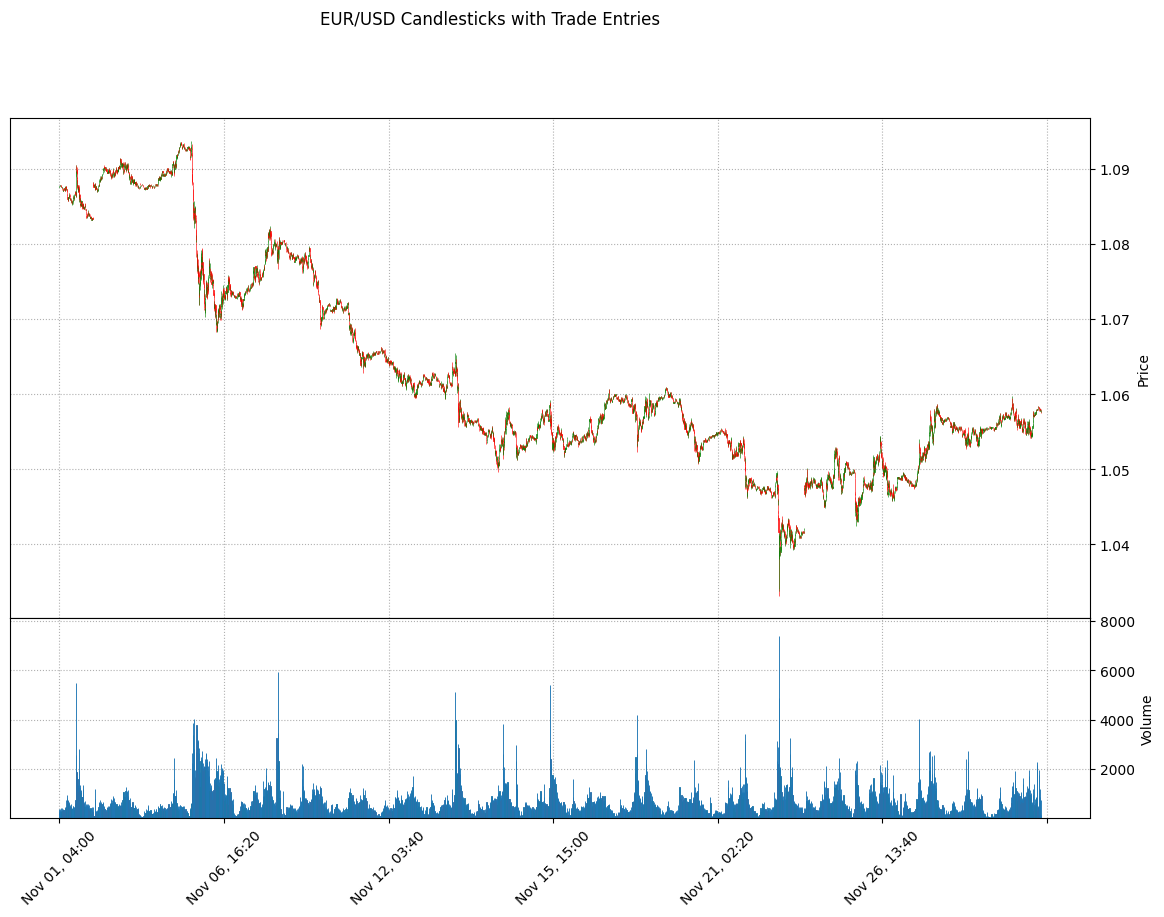


Backtest Results:


TypeError: 'TradeStats' object is not subscriptable

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
from datetime import timedelta

def plot_candlestick_trades(data, trades):
    # Convert Time column to datetime if it isn't already
    data['Time'] = pd.to_datetime(data['Time'])
    
    # Create a copy of the data to avoid modifying the original
    plot_data = data.copy()
    plot_data = plot_data.set_index('Time')
    
    # Ensure the index is sorted
    plot_data = plot_data.sort_index()
    
    # Style configuration
    mc = mpf.make_marketcolors(
        up='green', down='red',
        edge='inherit', wick='inherit',
        volume='in'
    )
    style = mpf.make_mpf_style(
        marketcolors=mc,
        gridstyle=':',
        y_on_right=True
    )
    
    # Create the base candlestick chart
    fig, axes = mpf.plot(
        plot_data,
        type='candle',
        style=style,
        title='EUR/USD Candlesticks with Trade Entries',
        volume=True,
        figsize=(15, 10),
        returnfig=True
    )
    
    # Get the main price axis
    ax1 = axes[0]
    
    # Add trade markers
    for trade in trades:
        entry_time = pd.to_datetime(trade['entry_time'])
        
        try:
            # Convert datetime to the chart's x-axis position
            date_index = plot_data.index.get_loc(entry_time)
            
            # Plot trade marker
            ax1.scatter(
                date_index,
                trade['entry_price'],
                color='purple',
                marker='o',
                s=100,
                zorder=5  # Ensure trades are plotted on top
            )
            
        except KeyError as e:
            print(f"Warning: Could not plot trade at {entry_time} - timestamp not found in data")
            continue
    
    # Adjust layout to prevent overlapping
    plt.tight_layout()
    
    return fig, axes

# Helper function to print backtest results
def print_backtest_results(stats):
    print("\nBacktest Results:")
    print(f"Total Trades: {stats['total_trades']}")
    print(f"Win Rate: {stats['win_rate']:.2f}%")
    print(f"Profit Factor: {stats['profit_factor']:.2f}")
    print(f"Final Balance: ${stats['final_balance']:.2f}")
    print(f"Total Return: {stats['total_return']:.2f}%")
    print(f"Max Drawdown: {stats['max_drawdown']:.2f}%")



backtester = SweepBacktester(
    initial_balance=100000,
    market_value=15000,
    risk_percent=100,
    reward_percent=600,
    max_bars=2
)

# Run backtest
stats = backtester.backtest(data)
trades = backtester.trades

# Create and show the plot
fig, axes = plot_candlestick_trades(data, trades)
plt.show()

# Print backtest results
print_backtest_results(stats)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np

def plot_candlestick_with_trades(data, trades):
    """
    Plot candlestick chart with sweep markers and trade entries
    """
    # Ensure data has datetime index
    data = data.copy()
    if 'Time' in data.columns:
        data['Time'] = pd.to_datetime(data['Time'])
        data = data.set_index('Time')
    
    # Create marker data arrays
    bearish_data = pd.Series(index=data.index, data=np.nan)
    bullish_data = pd.Series(index=data.index, data=np.nan)
    trade_entries = pd.Series(index=data.index, data=np.nan)
    
    # Fill in sweep markers
    bearish_data[data['signal'] == 1] = data['High'][data['signal'] == 1]
    bullish_data[data['signal'] == 2] = data['Low'][data['signal'] == 2]
    
    # Fill in trade entry points
    for trade in trades:
        entry_time = trade['entry_time']
        if trade['direction'] == 'long':
            trade_entries[entry_time] = data['Low'][entry_time]
        else:
            trade_entries[entry_time] = data['High'][entry_time]
    
    # Create plot with all markers
    apdict = [
        mpf.make_addplot(bearish_data, type='scatter', marker='v', 
                        markersize=100, color='red'),
        mpf.make_addplot(bullish_data, type='scatter', marker='^', 
                        markersize=100, color='green'),
        mpf.make_addplot(trade_entries, type='scatter', marker='o',
                        markersize=100, color='purple')
    ]
    
    # Style configuration
    mc = mpf.make_marketcolors(
        up='green', down='red',
        edge='inherit', wick='inherit',
        volume='in'
    )
    
    style = mpf.make_mpf_style(
        marketcolors=mc,
        gridstyle=':',
        y_on_right=True
    )
    
    # Create title with summary statistics
    sweep_counts = data['signal'].value_counts()
    bearish_count = sweep_counts.get(1, 0)
    bullish_count = sweep_counts.get(2, 0)
    total_trades = len(trades)
    winning_trades = sum(1 for trade in trades if trade['profit'] > 0)
    win_rate = (winning_trades / total_trades * 100) if total_trades > 0 else 0
    
    title = (f'EUR/USD Candlesticks with Sweeps and Trades\n'
             f'Bearish Sweeps: {bearish_count}, Bullish Sweeps: {bullish_count}\n'
             f'Total Trades: {total_trades}, Win Rate: {win_rate:.1f}%')
    
    # Create the plot
    fig, axes = mpf.plot(
        data,
        type='candle',
        style=style,
        title=title,
        volume=True,
        figsize=(15, 10),
        addplot=apdict,
        returnfig=True
    )
    
    plt.tight_layout()
    return fig, axes

# Create and display the plot
fig, axes = plot_candlestick_with_trades(data, trades)
plt.show()



def analyze_backtest_results(trades, initial_balance, final_balance):
    """
    Calculate and display detailed statistics for the backtest results
    """
    # Calculate basic metrics
    total_trades = len(trades)
    winning_trades = sum(1 for trade in trades if trade['profit'] > 0)
    win_rate = (winning_trades / total_trades * 100) if total_trades > 0 else 0
    
    # Calculate profit metrics
    total_profit = final_balance - initial_balance
    winning_profits = [trade['profit'] for trade in trades if trade['profit'] > 0]
    losing_profits = [trade['profit'] for trade in trades if trade['profit'] <= 0]
    
    avg_win = np.mean(winning_profits) if winning_profits else 0
    avg_loss = np.mean(losing_profits) if losing_profits else 0
    
    # Calculate profit factor
    gross_profits = sum(winning_profits) if winning_profits else 0
    gross_losses = abs(sum(losing_profits)) if losing_profits else 0
    profit_factor = gross_profits / gross_losses if gross_losses != 0 else float('inf')
    
    # Calculate max drawdown
    running_balance = initial_balance
    peak_balance = initial_balance
    max_drawdown = 0
    
    for trade in trades:
        running_balance += trade['profit']
        if running_balance > peak_balance:
            peak_balance = running_balance
        drawdown = peak_balance - running_balance
        if drawdown > max_drawdown:
            max_drawdown = drawdown
    
    # Print results
    print("=" * 37)
    print("=== SWEEP TRADER BACKTEST RESULTS ===")
    print("=" * 37)
    print(f"Initial Balance: ${initial_balance:,.2f}")
    print(f"Final Balance:   ${final_balance:,.2f}")
    print(f"P/L:            ${total_profit:,.2f}")
    print(f"Return:         {(total_profit/initial_balance*100):.2f}%")
    print(f"Total Trades:   {total_trades}")
    print(f"Win Rate:       {win_rate:.2f}%")
    print(f"Avg Win:        ${avg_win:.2f}")
    print(f"Avg Loss:       ${avg_loss:.2f}")
    print(f"Profit Factor:  {profit_factor:.2f}")
    print(f"Max Drawdown:   ${max_drawdown:.2f}")
    print("=" * 37)
    
    return {
        'total_trades': total_trades,
        'win_rate': win_rate,
        'avg_win': avg_win,
        'avg_loss': avg_loss,
        'profit_factor': profit_factor,
        'max_drawdown': max_drawdown
    }

# Calculate and display the statistics
stats = analyze_backtest_results(trades, initial_balance=100000, final_balance=final_balance)

NameError: name 'trades' is not defined

In [ ]:
def detect_sweeps_improved(df, length=5):
    """
    Simplified but effective sweep detector
    """
    signals = []
    pivot_highs = []
    pivot_lows = []
    
    for i in range(length + 1):
        signals.append(0)
    
    def is_pivot_high(window, mid_idx):
        mid_high = window.iloc[mid_idx]['High']
        left_section = window.iloc[:mid_idx]
        right_section = window.iloc[mid_idx+1:]
        return (mid_high > left_section['High'].max() and 
                mid_high > right_section['High'].max())
    
    def is_pivot_low(window, mid_idx):
        mid_low = window.iloc[mid_idx]['Low']
        left_section = window.iloc[:mid_idx]
        right_section = window.iloc[mid_idx+1:]
        return (mid_low < left_section['Low'].min() and 
                mid_low < right_section['Low'].min())
    
    # Main detection loop
    for i in range(length + 1, len(df)):
        current_candle = df.iloc[i]
        window = df.iloc[i-length-1:i]
        mid_idx = len(window) // 2
        
        signal = 0
        
        # Update pivot points
        if is_pivot_high(window, mid_idx):
            pivot_price = window.iloc[mid_idx]['High']
            pivot_highs.append({
                'price': pivot_price,
                'index': i-length//2,
                'active': True
            })
            
        if is_pivot_low(window, mid_idx):
            pivot_price = window.iloc[mid_idx]['Low']
            pivot_lows.append({
                'price': pivot_price,
                'index': i-length//2,
                'active': True
            })
        
        # Check for sweeps
        for ph in pivot_highs:
            if ph['active']:
                if (current_candle['High'] > ph['price'] and 
                    current_candle['Close'] < ph['price']):
                    signal = 1  # Bearish sweep
                    ph['active'] = False
                elif current_candle['Close'] > ph['price']:
                    ph['active'] = False
                    
        for pl in pivot_lows:
            if pl['active']:
                if (current_candle['Low'] < pl['price'] and 
                    current_candle['Close'] > pl['price']):
                    signal = 2  # Bullish sweep
                    pl['active'] = False
                elif current_candle['Close'] < pl['price']:
                    pl['active'] = False
        
        signals.append(signal)
        
        # Clean up old pivot points
        pivot_highs = [ph for ph in pivot_highs if i - ph['index'] <= 100]
        pivot_lows = [pl for pl in pivot_lows if i - pl['index'] <= 100]
    
    return signals

def run_backtest(data, initial_balance=100000, risk_percent=0.5, reward_percent=1.5, max_bars=5):
    """
    Simplified but robust backtest
    """
    balance = initial_balance
    trades = []
    active_trade = None
    
    # Prepare data
    data = data.copy()
    data['Time'] = pd.to_datetime(data['Time'])
    data.set_index('Time', inplace=True)
    
    # Add basic trend filter
    data['EMA20'] = data['Close'].ewm(span=20).mean()
    
    for i in range(len(data)):
        current_bar = data.iloc[i]
        current_time = data.index[i]
        
        # Handle existing trade
        if active_trade is not None:
            active_trade['bars_held'] += 1
            
            # Check stop loss
            if (active_trade['direction'] == 'long' and current_bar['Low'] <= active_trade['stop_loss']) or \
               (active_trade['direction'] == 'short' and current_bar['High'] >= active_trade['stop_loss']):
                profit = active_trade['position_size'] * (active_trade['stop_loss'] - active_trade['entry_price'])
                if active_trade['direction'] == 'short':
                    profit = -profit
                active_trade['exit_price'] = active_trade['stop_loss']
                active_trade['exit_time'] = current_time
                active_trade['profit'] = profit
                active_trade['exit_reason'] = 'stop_loss'
                trades.append(active_trade)
                balance += profit
                active_trade = None
                
            # Check take profit
            elif (active_trade['direction'] == 'long' and current_bar['High'] >= active_trade['take_profit']) or \
                 (active_trade['direction'] == 'short' and current_bar['Low'] <= active_trade['take_profit']):
                profit = active_trade['position_size'] * (active_trade['take_profit'] - active_trade['entry_price'])
                if active_trade['direction'] == 'short':
                    profit = -profit
                active_trade['exit_price'] = active_trade['take_profit']
                active_trade['exit_time'] = current_time
                active_trade['profit'] = profit
                active_trade['exit_reason'] = 'take_profit'
                trades.append(active_trade)
                balance += profit
                active_trade = None
                
            # Check max bars
            elif active_trade['bars_held'] >= max_bars:
                profit = active_trade['position_size'] * (current_bar['Close'] - active_trade['entry_price'])
                if active_trade['direction'] == 'short':
                    profit = -profit
                active_trade['exit_price'] = current_bar['Close']
                active_trade['exit_time'] = current_time
                active_trade['profit'] = profit
                active_trade['exit_reason'] = 'max_bars'
                trades.append(active_trade)
                balance += profit
                active_trade = None
        
        # Check for new trade if no active trade
        if active_trade is None and i > 20:  # Wait for EMA to warm up
            if current_bar['signal'] == 2:  # Bullish sweep
                # Only go long if price is near EMA20
                if abs(current_bar['Close'] - current_bar['EMA20']) / current_bar['Close'] < 0.0005:
                    entry_price = current_bar['Close']
                    stop_loss = current_bar['Low'] - (current_bar['High'] - current_bar['Low']) * 0.1
                    pip_risk = abs(entry_price - stop_loss)
                    position_size = (balance * risk_percent / 100) / pip_risk
                    take_profit = entry_price + pip_risk * (reward_percent / risk_percent)
                    
                    active_trade = {
                        'entry_time': current_time,
                        'direction': 'long',
                        'entry_price': entry_price,
                        'stop_loss': stop_loss,
                        'take_profit': take_profit,
                        'position_size': position_size,
                        'bars_held': 0
                    }
                    
            elif current_bar['signal'] == 1:  # Bearish sweep
                # Only go short if price is near EMA20
                if abs(current_bar['Close'] - current_bar['EMA20']) / current_bar['Close'] < 0.0005:
                    entry_price = current_bar['Close']
                    stop_loss = current_bar['High'] + (current_bar['High'] - current_bar['Low']) * 0.1
                    pip_risk = abs(stop_loss - entry_price)
                    position_size = (balance * risk_percent / 100) / pip_risk
                    take_profit = entry_price - pip_risk * (reward_percent / risk_percent)
                    
                    active_trade = {
                        'entry_time': current_time,
                        'direction': 'short',
                        'entry_price': entry_price,
                        'stop_loss': stop_loss,
                        'take_profit': take_profit,
                        'position_size': position_size,
                        'bars_held': 0
                    }
    
    return trades, balance

# Usage example:
import pandas as pd

def run_complete_backtest(data):
    """
    Run complete backtest with proper data preparation
    """
    # Add sweep signals
    data['signal'] = detect_sweeps_improved(data, length=5)
    
    # Run backtest
    trades, final_balance = run_backtest(
        data,
        initial_balance=100000,
        risk_percent=0.5,
        reward_percent=1.5,
        max_bars=5
    )
    
    # Print results
    print("\nBacktest Summary:")
    print("-" * 50)
    print(f"Initial Balance: ${100000:,.2f}")
    print(f"Final Balance: ${final_balance:,.2f}")
    print(f"Total Profit: ${(final_balance - 100000):,.2f}")
    print(f"Return: {((final_balance - 100000) / 100000 * 100):.2f}%")
    print(f"Number of Trades: {len(trades)}")
    
    if trades:
        winning_trades = sum(1 for t in trades if t['profit'] > 0)
        win_rate = (winning_trades / len(trades) * 100)
        print(f"Win Rate: {win_rate:.2f}%")
        
        # Calculate average win and loss
        wins = [t['profit'] for t in trades if t['profit'] > 0]
        losses = [t['profit'] for t in trades if t['profit'] <= 0]
        avg_win = sum(wins) / len(wins) if wins else 0
        avg_loss = sum(losses) / len(losses) if losses else 0
        print(f"Average Win: ${avg_win:.2f}")
        print(f"Average Loss: ${avg_loss:.2f}")
    
    return trades, final_balance